In [72]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [74]:
df = pd.read_csv('../../../Project/Data/recidivism_dataset_w_prs8.csv')

In [75]:
df.columns

Index(['Unnamed: 0', 'ID_VARIABLE', 'NEW_DOS', 'NEW_DOF', 'PRS', 'PRS8',
       'NEW_INC_SANCTION_EXISTS', 'ADJ_JPMIN', 'AT_RISK_DT', 'COUNTY',
       'NEXT_DOF', 'TIME_TO_RECIDIVATE', 'RECIDIVISM_3Y', 'RECIDIVISM_5Y',
       'OGS', 'MS_SANCTION', 'SEXCRIME', 'DUI', 'DRUGOFFENSE', 'FIREARMS',
       'VIOLENCE', 'DOB', 'OFF_RACE', 'OFF_SEX'],
      dtype='object')

In [76]:
df.head()

,Unnamed: 0,ID_VARIABLE,NEW_DOS,NEW_DOF,PRS,PRS8,NEW_INC_SANCTION_EXISTS,ADJ_JPMIN,AT_RISK_DT,COUNTY,...,OGS,MS_SANCTION,SEXCRIME,DUI,DRUGOFFENSE,FIREARMS,VIOLENCE,DOB,OFF_RACE,OFF_SEX
0,0,1000001,2010-02-18,2009-06-25,0,1.0,Y,16.0,2010-03-06,Schuylkill,...,3.0,5.0,False,False,False,False,False,1990-05-28,White,M
1,1,1000002,2017-01-31,2015-09-01,4,2.0,Y,120.0,2017-05-31,Somerset,...,3.0,3.0,False,True,False,False,False,1958-07-12,White,F
2,2,1000003,2002-05-08,2001-09-07,0,2.0,N,0.0,2002-05-08,Northampton,...,3.0,5.0,False,False,True,False,False,1961-08-14,White,F
3,3,1000003,2009-03-04,2009-03-04,3,3.0,Y,92.0,2009-06-04,Northampton,...,3.0,3.0,False,False,False,False,False,1961-08-14,White,F
4,4,1000004,2013-12-10,2013-09-19,0,2.0,N,0.0,2013-12-10,Franklin,...,1.0,5.0,False,False,True,False,False,1993-09-21,Unknown,M


In [77]:
sns.set_style(style='white') 
palette = ['#7B86BD', '#FFE347', '#F07B46', '#67E6AC', '#15B5FF' ]
race_palette = ['#7B86BD', '#FFE347', '#D3D3D3']
sns.set_palette(palette)

In [78]:
prs_labels = ['0', '1', '2', '3', '4', '5', 'RFEL/REVOC']
prs_labels_vert = ['0', '1', '2', '3', '4', '5', 'RFEL/\nREVOC']
prs8_labels =['0', 'Low', 'Medium', 'High']

In [79]:
df['NEW_DOF'] = pd.to_datetime(df['NEW_DOF'])

### Helper functions

In [156]:
def get_recidivism_rates(df, recidivism_var, level=None): 

    grp1 = 'PRS'
    grp2 = 'PRS8'
    if level is not None:
        grp1 = [grp1, level]
        grp2 = [grp2, level]
    prs = pd.DataFrame(df.groupby(by=grp1)[recidivism_var].sum() / df.groupby(by=grp1)[recidivism_var].count() * 100).reset_index()
    prs8 = pd.DataFrame(df.groupby(by=grp2)[recidivism_var].sum() / df.groupby(by=grp2)[recidivism_var].count() * 100).reset_index() 
    
    return prs, prs8

In [146]:
def get_recidivism_flags(df, next_dof_var, new_var):
    
    df[new_var] = np.where((df[next_dof_var]- df.NEW_DOF).dt.days <= 3 * 365.25, 1, 0)
    return df

In [164]:
def get_crime_type_stats(df, crime_var, label, level = None): 
    subset = df[df[crime_var]==True].copy()
  
    rec_prs, rec_prs8 = get_recidivism_rates(subset, 'RECIDIVISM_3Y', level = level)

    # recidivate to same crime
    subset['NEXT_DOF'] = subset.sort_values(by=['ID_VARIABLE', 'NEW_DOF'], ascending = [True, True]).groupby(by=['ID_VARIABLE'])['NEW_DOF'].shift(-1) 

    subset = get_recidivism_flags(subset, next_dof_var = 'NEXT_DOF', new_var = 'RECIDIVISM_' + crime_var + '_3Y') 

    if level is None: 
        overall_rate = subset['RECIDIVISM_3Y'].sum() / len(subset)
        print("overall {:s} recidivism rate: {:.4f} %".format(label, overall_rate * 100)) 
        
        same_rate = subset['RECIDIVISM_' + crime_var + '_3Y'].sum() / len(subset) 
        print('{:s} recidivating to {:s} rate: {:.4f}%'.format(label, label, same_rate * 100)) 

    else:
        values = df[level].unique()
        for i in values:
            overall_rate = subset[subset[level]==i]['RECIDIVISM_3Y'].sum() / len(subset[subset[level]==i])
            same_rate = subset[subset[level]==i]['RECIDIVISM_' + crime_var + '_3Y'].sum() / len(subset[subset[level]==i]) 
            print('\nRecidivism rates for {:s} = {:s}:'.format(level, i))
            print("overall {:s} recidivism rate: {:.4f} %".format(label, overall_rate * 100)) 
            print('{:s} recidivating to {:s} rate: {:.4f}%'.format(label, label, same_rate * 100)) 

    rec_same_prs, rec_same_prs8 = get_recidivism_rates(subset, 'RECIDIVISM_' + crime_var + '_3Y', level = level)   

    rec_same_prs.rename(columns = {'RECIDIVISM_'+crime_var+'_3Y': 'RECIDIVISM_3Y'}, inplace=True)
    rec_same_prs8.rename(columns = {'RECIDIVISM_'+crime_var+'_3Y': 'RECIDIVISM_3Y'}, inplace=True)

    rec_same_prs['RECID_TYPE'] = label
    rec_same_prs8['RECID_TYPE'] = label

    rec_prs['RECID_TYPE'] = 'Any'
    rec_prs8['RECID_TYPE'] = 'Any' 

    prs = pd.concat([rec_prs, rec_same_prs])
    prs8 = pd.concat([rec_prs8, rec_same_prs8])

    return prs, prs8    

In [166]:
def plot_crime_type(df1, df2, category=None, legend_loc = 'upper left', 
                y = 'RECIDIVISM_3Y', 
                palette = ['#7B86BD'] * 15, ylabel='Recidivism rate (%)',
                legend_title = None, hue_order = None, ylim=None, legend_size = 13, figsize = (14, 8)):
                

    fig, ax = plt.subplots(1, 2, figsize=figsize, sharey=True, gridspec_kw={'width_ratios':[1.75,1]}) 
    sns.set_palette(palette) 

    if ylim is not None:
        plt.ylim(0, ylim)

    if category is not None:
        p1 = sns.barplot(x='PRS', y=y, hue=category, data=df1,  ax=ax[0], hue_order = hue_order)
        p2 = sns.barplot(x='PRS8', y=y, hue=category, data=df2,  ax=ax[1], hue_order = hue_order)
        if legend_loc == 'upper left':
            ax[0].legend(loc= legend_loc, title = legend_title, prop={"size": legend_size}, title_fontsize = legend_size) 
            ax[1].get_legend().remove()
        elif legend_loc == 'upper right':
            ax[1].legend(loc= legend_loc, title = legend_title, prop={"size": legend_size}, title_fontsize = legend_size) 
            ax[0].get_legend().remove()
        n_cats = len(df1[category].unique())
        for a in range(2):
            for i in range(n_cats):
                ax[a].bar_label(ax[a].containers[i], label_type='edge', fmt='%1.1f', fontsize=13)
        
    else: 
        p1 = sns.barplot(x='PRS', y=y, data=df1,  ax=ax[0])
        p2 = sns.barplot(x='PRS8', y=y, data=df2,  ax=ax[1])
        for a in range(2):
            ax[a].bar_label(ax[a].containers[0], label_type='edge', fmt='%1.1f', fontsize=13)

    sns.despine(top=True, right=True, left=True, bottom=True)

    p1.set(xticklabels = prs_labels)
    p2.set(xticklabels = prs8_labels) 
        
    p1.set_title('7th Edition', fontsize=15)
    p2.set_title('8th Edition', fontsize=15)
    plt.suptitle('PRS category', x=0.5, y=0.05, fontsize=15)
    p1.set_ylabel(ylabel, fontsize=15)
    p1.set(yticklabels=[])
    p2.set_ylabel(None)
    p2.set(yticklabels=[])
    p1.set_xlabel(None)
    p2.set_xlabel(None)

    #p1.xticks(fontsize=15)
    #p2.xticks(fontsize=15) 
    p1.tick_params(axis='both', which='major', labelsize=13)
    p2.tick_params(axis='both', which='major', labelsize=13)


    plt.subplots_adjust(wspace=0.1)
    plt.show()

### Drug offenses

In [151]:
drug_prs, drug_prs8 = get_crime_type_stats(df, 'DRUGOFFENSE', 'Drug')

overall Drug recidivism rate: 19.8744 %
Drug recidivating to Drug rate: 11.3240%


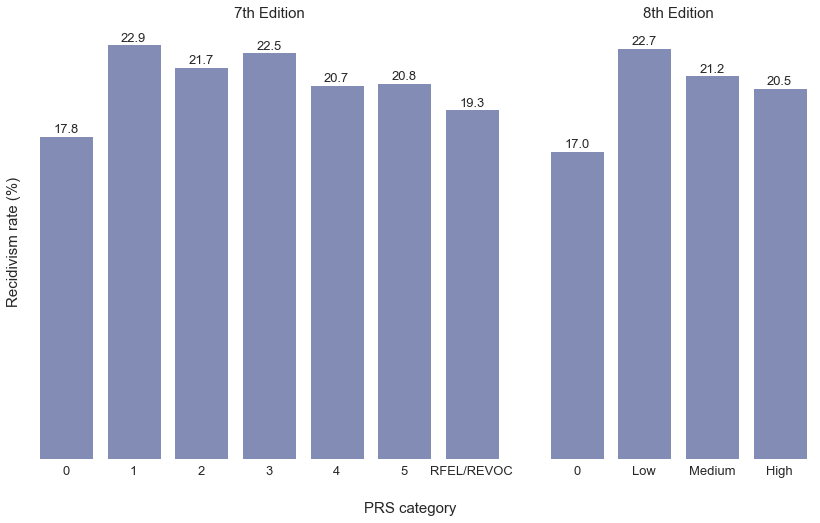

In [83]:
# overall drug recidivism rates (recidivate to any crime) by PRS
# plot_crime_type(drug_rec_prs, drug_rec_prs8)

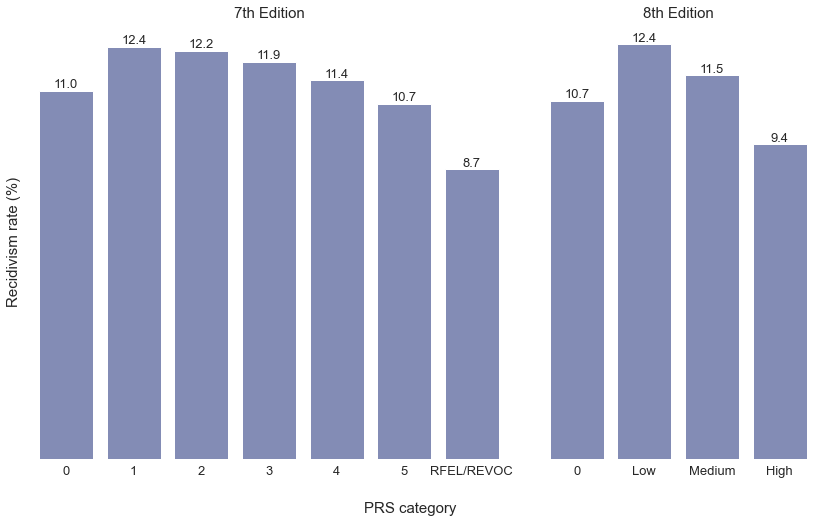

In [91]:
# # drug crime recidivating to another drug crime 
# plot_crime_type(drug_drug_prs, drug_drug_prs8, y='RECIDIVISM_DRUG_3Y')

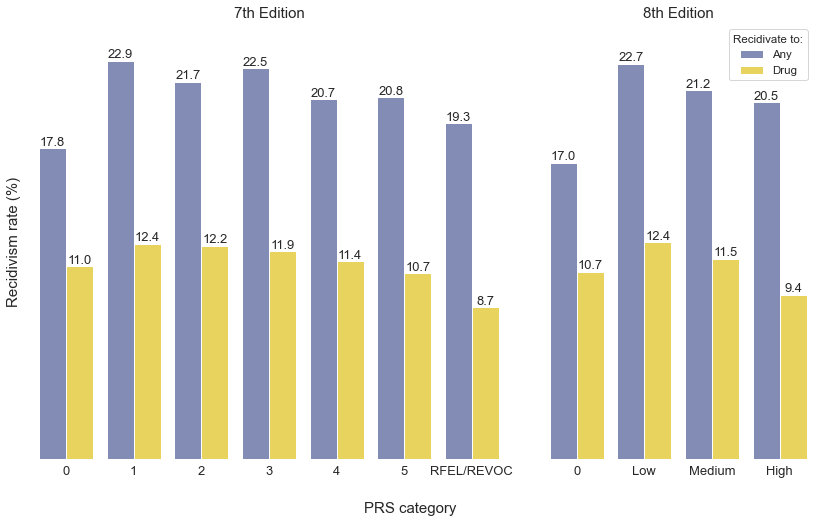

In [152]:
plot_crime_type(drug_prs, drug_prs8, category='RECID_TYPE', palette = palette,  hue_order = ['Any', 'Drug'], legend_loc = 'upper right', legend_size = 11.5, legend_title='Recidivate to:', ylim=25)

In [167]:
drug_race_prs, drug_race_prs8 = get_crime_type_stats(df[df['OFF_RACE'].isin(['Black', 'White'])], crime_var = 'DRUGOFFENSE', label = 'Drug', level = 'OFF_RACE')


Recidivism rates for OFF_RACE = White:
overall Drug recidivism rate: 20.8380 %
Drug recidivating to Drug rate: 11.5730%

Recidivism rates for OFF_RACE = Black:
overall Drug recidivism rate: 19.7129 %
Drug recidivating to Drug rate: 11.6216%


Plotting results for recidiviating to Any crime


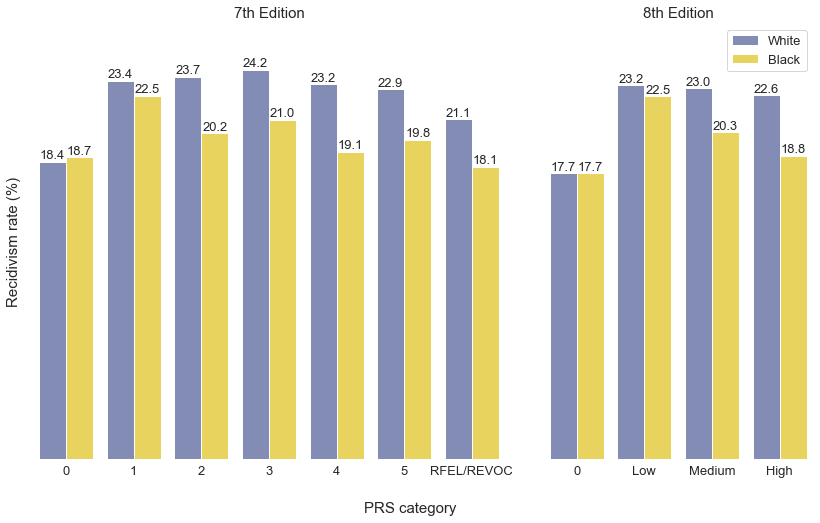

Plotting results for recidiviating to Drug crime


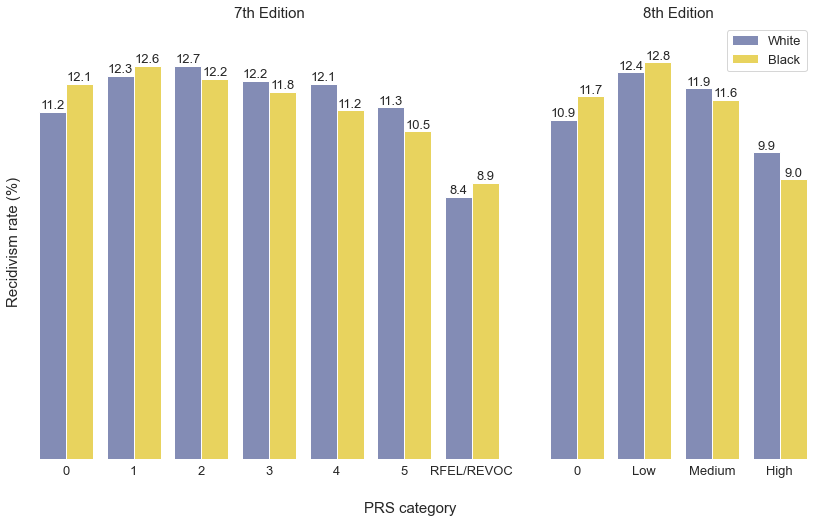

In [178]:
# recidivating to any crime
ylim = [27, 14]
types = ['Any', 'Drug']
for i in range(len(types)):
    t = types[i]
    print('Plotting results for recidiviating to {} crime'.format(t))
    plot_crime_type(drug_race_prs[drug_race_prs['RECID_TYPE'] == t], drug_race_prs8[drug_race_prs8['RECID_TYPE'] == t], 
    palette = race_palette, hue_order = ['White', 'Black'], category='OFF_RACE', legend_loc = 'upper right', ylim = ylim[i])

In [ ]:
# drug offenses by race

def plot_crime_type(df1, df2, category=None, legend_loc = 'upper left', 
                x = 'PRS', y = 'RECIDIVISM_3Y', 
                palette = ['#7B86BD'] * 15, ylabel='Recidivism rate (%)',
                legend_title = None, hue_order = None, ylim=None, legend_size = 13, figsize = (14, 8)): 

### DUIs

In [180]:
dui_prs, dui_prs8 = get_crime_type_stats(df, 'DUI', 'DUI')

overall DUI recidivism rate: 12.1445 %
DUI recidivating to DUI rate: 6.6231%


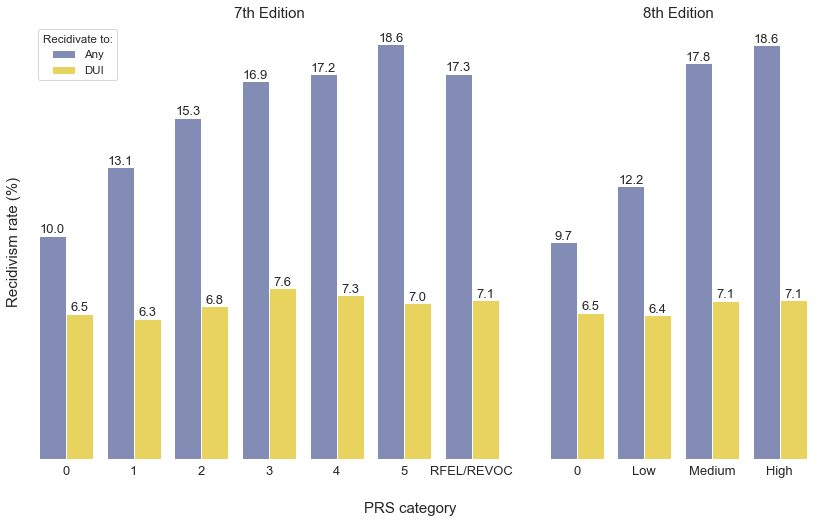

In [132]:
plot_crime_type(dui_prs, dui_prs8, category='RECID_TYPE', palette = palette,  hue_order = ['Any', 'DUI'], legend_loc = 'upper left', legend_size = 11.5, legend_title='Recidivate to:')

In [179]:
# DUI by race

dui_race_prs, dui_race_prs8 = get_crime_type_stats(df[df['OFF_RACE'].isin(['Black', 'White'])], crime_var = 'DUI', label = 'DUI', level = 'OFF_RACE')


Recidivism rates for OFF_RACE = White:
overall DUI recidivism rate: 11.8994 %
DUI recidivating to DUI rate: 6.7670%

Recidivism rates for OFF_RACE = Black:
overall DUI recidivism rate: 15.3738 %
DUI recidivating to DUI rate: 6.3291%


Plotting results for recidiviating to Any crime


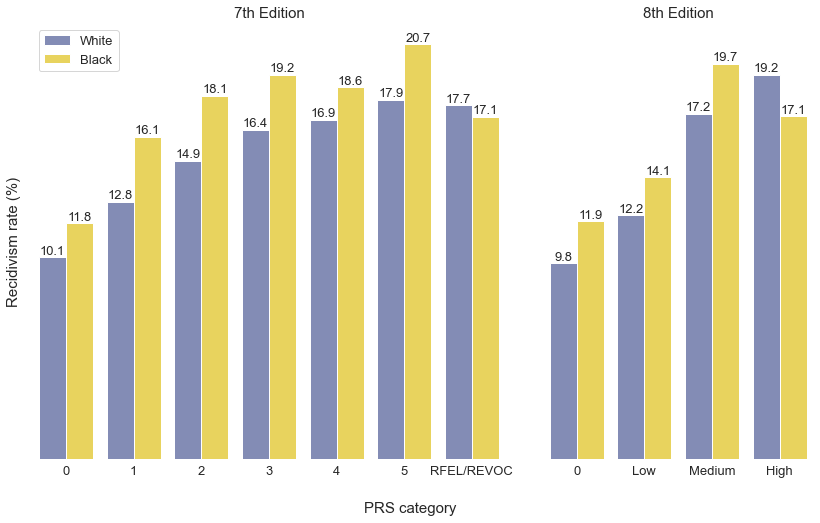

Plotting results for recidiviating to DUI crime


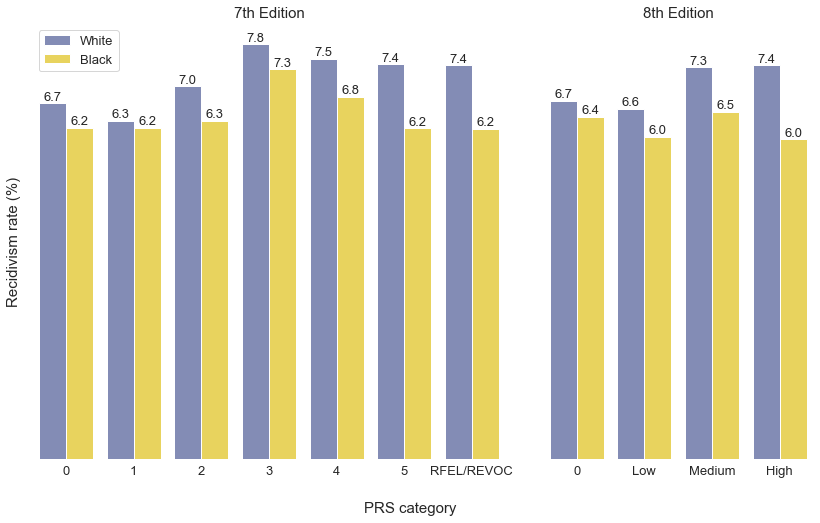

In [183]:
# recidivating to any crime
ylim = [None, None]
types = ['Any', 'DUI']
for i in range(len(types)):
    t = types[i]
    print('Plotting results for recidiviating to {} crime'.format(t))
    plot_crime_type(dui_race_prs[dui_race_prs['RECID_TYPE'] == t], dui_race_prs8[dui_race_prs8['RECID_TYPE'] == t], 
    palette = race_palette, hue_order = ['White', 'Black'], category='OFF_RACE', legend_loc = 'upper left', ylim = ylim[i])

### Felony

In [134]:
df['FELONY'] = np.where(df['OGS']>=5, True, False)

In [135]:
df['PRS'].unique()

array(['0', '4', '3', 'RFEL', '2', '5', '1'], dtype=object)

In [140]:
fel_prs, fel_prs8 = get_crime_type_stats(df, 'FELONY', 'Felony')

overall Felony recidivism rate: 14.1975 %
Felony recidivating to Felony rate: 8.7066%


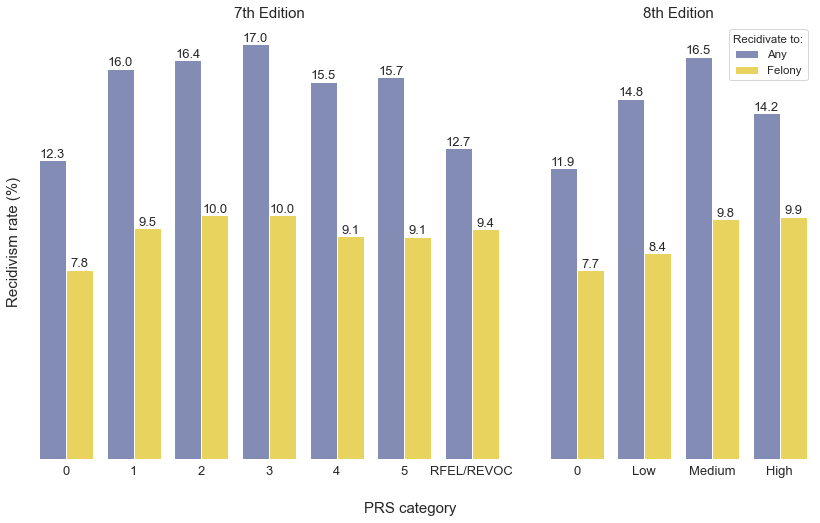

In [143]:
plot_crime_type(fel_prs, fel_prs8, category='RECID_TYPE', palette = palette,  hue_order = ['Any', 'Felony'], legend_loc = 'upper right', legend_size = 11.5, legend_title='Recidivate to:')

In [184]:
# Felony by race
fel_race_prs, fel_race_prs8 = get_crime_type_stats(df[df['OFF_RACE'].isin(['Black', 'White'])], crime_var = 'FELONY', label = 'Felony', level = 'OFF_RACE')


Recidivism rates for OFF_RACE = White:
overall Felony recidivism rate: 14.1700 %
Felony recidivating to Felony rate: 8.4660%

Recidivism rates for OFF_RACE = Black:
overall Felony recidivism rate: 15.2762 %
Felony recidivating to Felony rate: 9.6006%


Plotting results for recidiviating to Any crime


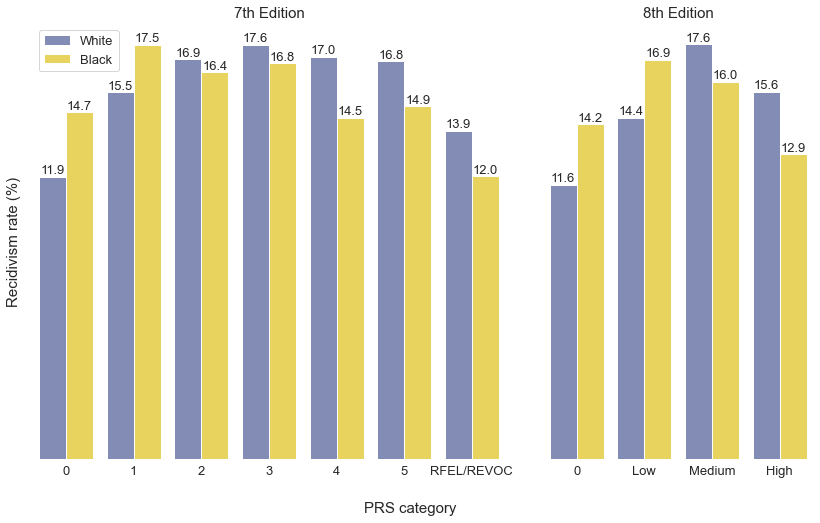

Plotting results for recidiviating to Felony crime


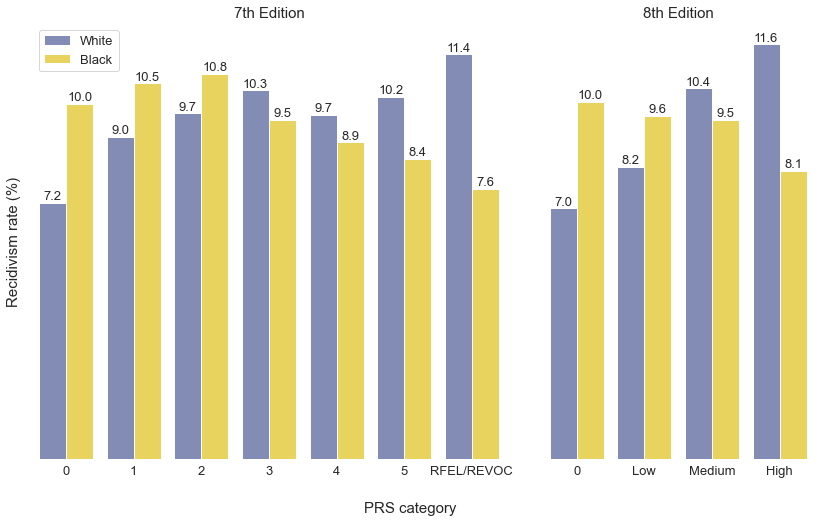

In [185]:
# recidivating to any crime
ylim = [None, None]
types = ['Any', 'Felony']
for i in range(len(types)):
    t = types[i]
    print('Plotting results for recidiviating to {} crime'.format(t))
    plot_crime_type(fel_race_prs[fel_race_prs['RECID_TYPE'] == t], fel_race_prs8[fel_race_prs8['RECID_TYPE'] == t], 
    palette = race_palette, hue_order = ['White', 'Black'], category='OFF_RACE', legend_loc = 'upper left', ylim = ylim[i])